In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/TLB/Taro_Unique"

Taro_Early_Blight  Taro_Healthy  Taro_Late_Blight  Taro_Mid_Blight


In [ ]:
!ls "/content/drive/MyDrive/Taro Leave Blight Images/Enugu_State_Data"

Taro_Early_Blight  Taro_Healthy  Taro_Late_Blight  Taro_Mid_Blight


In [ ]:
import os
import shutil

In [ ]:
dir1 = "/content/drive/MyDrive/Taro Leave Blight Images/Ghana_Data"
dir2 = "/content/drive/MyDrive/Taro Leave Blight Images/Ebonyi_State Data"
dir3 = "/content/drive/MyDrive/Taro Leave Blight Images/Ghana_Data_Flattened"
dir4 = "/content/drive/MyDrive/Taro Leaf Blight Images/Taro Leave Blight Images/Ghana_Data"
dir5 = "/content/drive/MyDrive/Taro_Ghana_Backup"
dir6 = "/content/drive/MyDrive/TLB/Taro Leave Blight Images"
dir7 = "/content/drive/MyDrive/TLB/Taro Leave Blight Images2"
dir8 = "/content/drive/MyDrive/Taro Leave Blight Images/Enugu_State_Data"
dir9 = "/content/drive/MyDrive/Taro_Full_Dataset"
dir10 = "/content/drive/MyDrive/TLB/Taro_Unique"
dir11 = "/content/drive/MyDrive/TLB/Taro Leaf Blight 3"


dir1_sfx = "ghana"
dir2_sfx = "ebonyi"
dir3_sfx = "enugu"
dir4_sfx = "oby"

In [ ]:
!cp -r "/content/drive/MyDrive/Taro Leave Blight Images/Ghana_Data" "/content/drive/MyDrive/Taro_Ghana_Backup/"

### Flatten the Ghana dataset (tentative)

In [ ]:
def copy_files_to_root(folder_path):
    fs = []
    for root, dirs, files in os.walk(folder_path):
        for (i, filename) in enumerate(files):
            if os.path.isfile(os.path.join(root, filename)):
                fs.append(os.path.join(root, filename))

    for f in fs:
      print(f"copying {f}")
      shutil.copy(f, folder_path)

In [ ]:
dir = dir1
# Get the list of subfolders (classes)
subfolders = [folder for folder in os.listdir(dir) if os.path.isdir(os.path.join(dir, folder))]
# Folders to avoid
avoid_folders = ["Taro Leave Blight Images"]

# Filter out the folders to avoid
subfolders = [folder for folder in subfolders if folder not in avoid_folders]

for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  copy_files_to_root(subfolder_path)

### Checking for duplicates

In [ ]:
import cv2
import numpy as np
import re

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    return keypoints, descriptors

def match_features(descriptor1, descriptor2, index_params, search_params):
    # Initialize Flann matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # Match descriptors
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)

    if len(matches) == 0:
      return 0

    # Ratio test to filter good matches
    good_matches = []
    for match_pair in matches:
        if len(match_pair) < 2:
            continue
        m, n = match_pair
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    return len(good_matches)

def are_images_identical(a, b):
  FLANN_INDEX_LSH = 6
  index_params = dict(algorithm=FLANN_INDEX_LSH,
                      table_number=6,
                      key_size=12,
                      multi_probe_level=1)
  search_params = dict(checks=50)

  keypoints1, descriptors1 = extract_features(a)
  keypoints2, descriptors2 = extract_features(b)

  num_matches = match_features(descriptors1, descriptors2, index_params, search_params)

  if num_matches > 10:
      return True
  else:
      return False

def get_duplicates(folder_path, target_size=(640, 640)):
    fs = []
    arrs = []
    for root, dirs, files in os.walk(folder_path):
        for (i, filename) in enumerate(files):
            if os.path.isfile(os.path.join(root, filename)):
                a = cv2.imread(os.path.join(root, filename))
                a = cv2.resize(a, dsize=target_size)
                arrs.append(a)
                fs.append(os.path.join(root, filename))

    identicals = {}
    print(len(fs))
    for i in range(len(fs)):
      i_identicals = []
      for j in range(len(fs)):
        if i == j:
          continue
        if are_images_identical(arrs[i], arrs[j]):
          i_identicals.append(fs[j])
      identicals[fs[i]] = i_identicals
    return identicals

def get_duplicates_with_filename(folder_path, target_size=(640, 640)):
    fs = []
    arrs = []
    for root, dirs, files in os.walk(folder_path):
        for (i, filename) in enumerate(files):
            if os.path.isfile(os.path.join(root, filename)):
                fs.append(os.path.join(root, filename))

    identicals = {}
    for i in range(len(fs)):
      i_identicals = []
      for j in range(6):
        if i+j > len(fs) - 1:
          continue
        if are_images_identical3(fs[i], fs[i+j]):
          i_identicals.append(fs[i+j])
      identicals[fs[i]] = i_identicals
    return identicals


def are_images_identical3(a, b):
  # Index and search parameters for Flann matcher
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)

  # Extract features from images
  keypoints1, descriptors1 = extract_features(a)
  keypoints2, descriptors2 = extract_features(b)

  # Match features
  num_matches = match_features(descriptors1, descriptors2, index_params, search_params)

  # Determine if there's a match
  if num_matches > 10:  # Adjust threshold as needed
      return True
  else:
      return False


def are_images_identical2(a, b, target_size=(640, 640)):
  difference = np.subtract(a, b)
  total_sum = np.sum(difference)
  print(total_sum)
  if total_sum == 0:
    return True
  else:
    return False

def are_images_identical3(a, b):
  pattern = r'IMG_(\d{8})_(\d{4})'
  matches1 = re.search(pattern, a)
  matches2 = re.search(pattern, b)

  if matches1 and matches2:
      img_id_1 = matches1.group(1)
      time_code_1 = matches1.group(2)
      img_id_2 = matches2.group(1)
      time_code_2 = matches2.group(2)
      if img_id_1 == img_id_2 and time_code_1 == time_code_2:
        return True
      else:
        return False
  else:
      return False

In [ ]:
dir = dir6
# Get the list of subfolders (classes)
subfolders = [folder for folder in os.listdir(dir) if os.path.isdir(os.path.join(dir, folder))]
# Folders to avoid
avoid_folders = [""]

# Filter out the folders to avoid
subfolders = [folder for folder in subfolders if folder not in avoid_folders]

total_files = 0
duplicates_all = []
for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  duplicates = get_duplicates_with_filename(subfolder_path)
  duplicates_all.append(duplicates)
  print(f"\nFiles in {subfolder}")
  print(f"\n{duplicates}")


Files in Taro_Free

{'/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134736_407.jpg': ['/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134736_407.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134741_555.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134741_988.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134742_453.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134746_954.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134746_183.jpg'], '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134741_555.jpg': ['/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134741_555.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134741_988.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight

In [ ]:
count = 0
deleted = []
unique = []
for key, value in duplicates_all[3].items():
    if key in deleted:
        continue
    if key in unique:
        continue
    p = re.compile(r"/content/drive/MyDrive/TLB/")
    unique.append(key)
    if len(value) > 0:
        for v in value:
            if v in deleted:
                continue
            count += 1
            try:
                deleted.append(v)
            except:
                continue

print(len(unique))

369


In [ ]:
dir = dir10

subfolders = ["Taro_Healthy", "Taro_Mid_Blight", "Taro_Late_Blight", "Taro_Early_Blight"]
for source_file in unique:
  filename = os.path.basename(source_file)
  dest_dir = os.path.join(dir, subfolders[3])
  destination_file = os.path.join(dest_dir, filename)
  print(destination_file)
  shutil.copyfile(source_file, destination_file)

### Remove duplicates

In [ ]:
# File path to the JSON file
file_path = "/content/drive/MyDrive/duplicates_check/duplicates_ghana/late.json"

# Load JSON data from file
with open(file_path, "r") as json_file:
    data_dict = json.load(json_file)

keys_list = list(data_dict.keys())
count = 0
deleted = []
for key, value in data_dict.items():
  if key in deleted:
        continue
  if len(value) > 0:
    for v in value:
      if v in deleted:
        continue
      count += 1
      try:
        shutil.os.remove(v)
        deleted.append(v)
      except:
        continue
print(count)

51


### Count images in original source folder

In [ ]:
def count_files(folder_path):
    file_count = 0

    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

In [ ]:
'''
Files in Taro_Mid_Blight and its subfolders: 307
		Files in Taro_Healthy and its subfolders: 1545
		Files in Taro_Early_Blight and its subfolders: 584
		Files in Taro_Late_Blight and its subfolders: 400
		Total Files in /content/drive/MyDrive/Taro Leave Blight Images/Ghana_Data and its subfolders: 2836
'''

In [ ]:
dir = dir10
# Get the list of subfolders (classes)
subfolders = [folder for folder in os.listdir(dir) if os.path.isdir(os.path.join(dir, folder))]
print(subfolders)

# Folders to avoid
avoid_folders = ["Taro Leave Blight Images"]

# Filter out the folders to avoid
subfolders = [folder for folder in subfolders if folder not in avoid_folders]

total_files = 0
for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  files = count_files(subfolder_path)
  total_files += files
  print(f"Files in {subfolder} and its subfolders: {files}")
print(f"Total Files in {dir} and its subfolders: {total_files}")

['Taro_Healthy', 'Taro_Late_Blight', 'Taro_Mid_Blight', 'Taro_Early_Blight']
Files in Taro_Healthy and its subfolders: 384
Files in Taro_Late_Blight and its subfolders: 217
Files in Taro_Mid_Blight and its subfolders: 157
Files in Taro_Early_Blight and its subfolders: 437
Total Files in /content/drive/MyDrive/TLB/Taro_Unique and its subfolders: 1195


In [ ]:
dir = dir11
# Get the list of subfolders (classes)
subfolders = [folder for folder in os.listdir(dir) if os.path.isdir(os.path.join(dir, folder))]
print(subfolders)

# Folders to avoid
avoid_folders = ["Taro Leave Blight Images"]

# Filter out the folders to avoid
subfolders = [folder for folder in subfolders if folder not in avoid_folders]

total_files = 0
for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  files = count_files(subfolder_path)
  total_files += files
  print(f"Files in {subfolder} and its subfolders: {files}")
print(f"Total Files in {dir} and its subfolders: {total_files}")

['Taro_Blight_Early', 'Taro_Blight_Free', 'Taro_Blight_Late', 'Taro_Blight_Mid']
Files in Taro_Blight_Early and its subfolders: 188
Files in Taro_Blight_Free and its subfolders: 385
Files in Taro_Blight_Late and its subfolders: 56
Files in Taro_Blight_Mid and its subfolders: 86
Total Files in /content/drive/MyDrive/TLB/Taro Leaf Blight 3 and its subfolders: 715


In [ ]:
dir = dir2
# Get the list of subfolders (classes)
subfolders = [folder for folder in os.listdir(dir) if os.path.isdir(os.path.join(dir, folder))]

# Folders to avoid
avoid_folders = ["Taro Leave Blight Images"]

# Filter out the folders to avoid
subfolders = [folder for folder in subfolders if folder not in avoid_folders]

total_files = 0
for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  files = count_files(subfolder_path)
  total_files += files
  print(f"Files in {subfolder} and its subfolders: {files}")
print(f"Total Files in {dir} and its subfolders: {total_files}")

'''
484,317,832,1579
'''
'''
Taro late,Taro mid,Taro early,Taro healthy
'''


Files in Taro_Mid_Blight and its subfolders: 790
Files in Taro_Early_Blight and its subfolders: 1231
Files in Taro_Healthy and its subfolders: 469
Files in Taro_Late_Blight and its subfolders: 451
Total Files in /content/drive/MyDrive/Taro Leave Blight Images/Ebonyi_State Data and its subfolders: 2941


'\nTaro late,Taro mid,Taro early,Taro healthy\n'

### Calculate total size of images in folder

In [ ]:
def calculate_total_size_in_gb(folder_path):
    total_size = 0
    total_files = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            total_files += 1
            file_path = os.path.join(root, file)
            total_size += os.path.getsize(file_path)
    total_size_gb = total_size / (1024 * 1024 * 1024)
    return total_size_gb, total_files

In [ ]:
dir = dir2
# Example usage:
folder_path = dir
total_size, total_files = calculate_total_size_in_gb(folder_path)
print(f"Total size of files in '{folder_path}': {total_size} GB")
print(f"Total files: {total_files}")

Total size of files in '/content/drive/MyDrive/Taro Leave Blight Images/Ebonyi_State Data': 5.061261252500117 GB
Total files: 2941


In [ ]:
img = "/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Late_Blight/IMG_20240116_134527_840.jpg"
size = os.path.getsize(img)
print(size)

6349229


### Merge the dataset into one folder

In [ ]:
from PIL import Image
import os
import uuid
import hmac
import hashlib
import base64

secret = "taro_leaf_blight_project"

def encode(msg, secret):
    alg = hashlib.sha256
    dig = hmac.new(bytes(secret, "utf-8"), msg=bytes(msg, "utf-8"), digestmod=alg).digest()
    dec = base64.urlsafe_b64encode(dig).decode().rstrip('=')
    return dec

def save_filenames_to_text(filename, output_file):
    with open(output_file, 'w') as f:
      f.write(filename + '\n')

def resize_image_and_save(input_path, output_folder, output_path, target_size=(640, 640)):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    try:
        # Open image file
        with Image.open(input_path) as img:
            # Resize image
            img_resized = img.resize(target_size)
            # Save resized image to output directory
            img_resized.save(output_path)
            print(f"Resized {input_path} successfully.")
    except Exception as e:
        print(f"Error resizing {input_path}: {e}")




def create_full_dataset(name, idx, folder_path, destination_folder, source_ledger, dest_ledger):
  with open(source_ledger, 'r') as f:
    filenames = set(line.strip() for line in f)

    for root, dirs, files in os.walk(folder_path):
      if len(files) > 0:
        with open(dest_ledger, 'a') as f:
          with open(source_ledger, 'a') as s:
            for (i, source_fil) in enumerate(files):
                source_file = os.path.join(root, source_fil)
                if source_file not in filenames:
                  fil = f"{name}{str(idx)}.jpg"
                  f.write(fil + '\n')
                  s.write(source_file + '\n')
                  destination_file = os.path.join(destination_folder, fil)
                  resize_image_and_save(source_file, destination_folder, destination_file)
                  idx += 1
                  # shutil.copyfile(source_file, destination_file)

In [ ]:
# 4, 2, 8, 10, 11 (1, 2, 3, 4, 4)
dir = dir11
dir_sfx = dir4_sfx

src = "/content/drive/MyDrive/Taro_Full_Dataset"
# Get the list of subfolders (classes)
subfolders = [folder for folder in os.listdir(dir) if os.path.isdir(os.path.join(dir, folder))]

# Folders to avoid
avoid_folders = ["Taro Leave Blight Images"]

# Filter out the folders to avoid
subfolders = [folder for folder in subfolders if folder not in avoid_folders]

name = {
    "Taro_Early_Blight":"e",
    "Taro_Healthy":"h",
    "Taro_Late_Blight": "l",
    "Taro_Mid_Blight":"m"
    }
idx = {"Taro_Mid_Blight":1777,
       "Taro_Healthy": 3639,
       "Taro_Early_Blight": 3476,
       "Taro_Late_Blight": 1195
       }
name_to_standard = {
    "Taro_Blight_Early":"Taro_Early_Blight",
    "Taro_Blight_Free":"Taro_Healthy",
    "Taro_Blight_Late": "Taro_Late_Blight",
    "Taro_Blight_Mid":"Taro_Mid_Blight"
    }
# name = {
#     "Taro_Blight_Early":"e",
#     "Taro_Blight_Free":"h",
#     "Taro_Blight_Late": "l",
#     "Taro_Blight_Mid":"m"
#     }
# idx = {"Taro_Blight_Mid":1692,
#        "Taro_Blight_Free": 3255,
#        "Taro_Blight_Early": 3289,
#        "Taro_Blight_Late": 1140
#        }
for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  subfolder = name_to_standard[subfolder]
  destination_folder = os.path.join(src, subfolder)
  dest_ledger = os.path.join(src, f"{dir_sfx}_{subfolder}.txt")
  source_ledger = os.path.join(src, f"source_{dir_sfx}_{subfolder}.txt")

  with open(dest_ledger, 'w') as f:
    print(dest_ledger)
    f.close()
  with open(source_ledger, 'w') as f:
    print(source_ledger)
    f.close()

  create_full_dataset(name[subfolder], idx[subfolder], subfolder_path, destination_folder, source_ledger, dest_ledger)

### Count images in merged full dataset

In [ ]:
dir = "/content/drive/MyDrive/Taro_Full_Dataset"
# Get the list of subfolders (classes)
subfolders = [folder for folder in os.listdir(dir) if os.path.isdir(os.path.join(dir, folder))]

# Folders to avoid
avoid_folders = ["Taro Leave Blight Images", "Taro_Not_Early", "zips"]

# Filter out the folders to avoid
subfolders = [folder for folder in subfolders if folder not in avoid_folders]
total_files = 0
for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  files = count_files(subfolder_path)
  total_files += files
  print(f"Files in {subfolder} and its subfolders: {files}")
print(f"Total Files in {dir} and its subfolders: {total_files}")

Files in Taro_Mid_Blight and its subfolders: 1777
Files in Taro_Healthy and its subfolders: 3639
Files in Taro_Early_Blight and its subfolders: 3476
Files in Taro_Late_Blight and its subfolders: 1195
Total Files in /content/drive/MyDrive/Taro_Full_Dataset and its subfolders: 10087


In [ ]:
dir = "/content/drive/MyDrive/Taro_Full_Dataset"
# Get the list of subfolders (classes)
subfolders = [folder for folder in os.listdir(dir) if os.path.isdir(os.path.join(dir, folder))]

# Folders to avoid
avoid_folders = ["Taro Leave Blight Images", "Taro_Not_Early", "zips"]

# Filter out the folders to avoid
subfolders = [folder for folder in subfolders if folder not in avoid_folders]
total_files = 0
for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  files = count_files(subfolder_path)
  total_files += files
  print(f"Files in {subfolder} and its subfolders: {files}")
print(f"Total Files in {dir} and its subfolders: {total_files}")

Files in Taro_Mid_Blight and its subfolders: 1691
Files in Taro_Healthy and its subfolders: 3254
Files in Taro_Early_Blight and its subfolders: 3288
Files in Taro_Late_Blight and its subfolders: 1139
Total Files in /content/drive/MyDrive/Taro_Full_Dataset and its subfolders: 9372


### Merge Taro-Late and Taro-Mid into Not-Early

In [ ]:
def copy_files(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for filename in os.listdir(source_folder):
        source_file = os.path.join(source_folder, filename)
        destination_file = os.path.join(destination_folder, filename)
        print(destination_file)
        shutil.copyfile(source_file, destination_file)

In [ ]:
dir = "/content/drive/MyDrive/Taro_Full_Dataset"

subfolders = ["Taro_Late_Blight", "Taro_Mid_Blight"]
destination = "Taro_Not_Early"
for subfolder in subfolders:
  subfolder_path = os.path.join(dir, subfolder)
  destination_path = os.path.join(dir, destination)
  copy_files(subfolder_path, destination_path)

In [ ]:
destination = "Taro_Not_Early"
subfolder_path = os.path.join(dir, destination)
files = count_files(subfolder_path)
print(f"Files in {subfolder_path} and its subfolders: {files}")

Files in /content/drive/MyDrive/Taro_Full_Dataset/Taro_Not_Early and its subfolders: 2972


### Zip full dataset

In [ ]:
shutil.make_archive("/content/drive/MyDrive/Taro_Full_Dataset/zips/taro_mid", 'zip', "/content/drive/MyDrive/Taro_Full_Dataset/Taro_Mid_Blight")

'/content/drive/MyDrive/Taro_Full_Dataset/zips/taro_mid.zip'

In [ ]:
imgs = ['/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134736_407.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134741_555.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134741_988.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134742_453.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134746_954.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134746_183.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134747_302.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134747_800.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134757_595.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134757_012.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134758_603.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Free/IMG_20240116_134757_984.jpg']
imgs = ['/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165330_680 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165330_680 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165330_680.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165332_691 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165333_651 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165355_422 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165331_749 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165355_422.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165331_749.jpg']
imgs = ['/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165330_680 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165330_680 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165330_680.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165332_691 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165333_651 (1).jpg']
imgs =  ['/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165330_680.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165332_691 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165333_651 (1).jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165355_422 (1).jpg']

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

def display_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, dsize=(250, 250))
    cv2_imshow(image)

/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733 (1).jpg


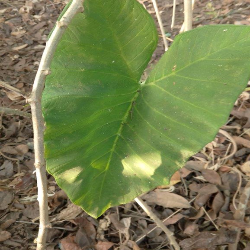

/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733 (1).jpg


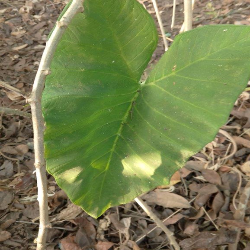

/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165329_733.jpg


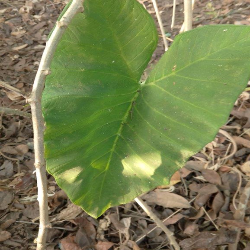

/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165330_680.jpg


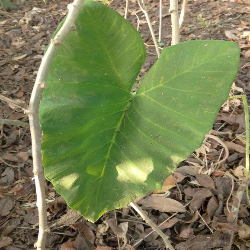

/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165332_691 (1).jpg


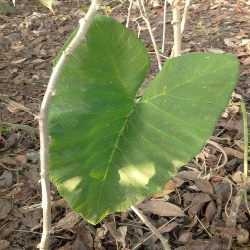

/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165333_651 (1).jpg


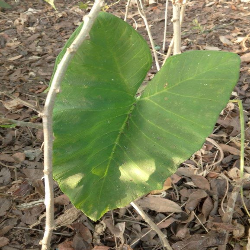

/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240117_165355_422 (1).jpg


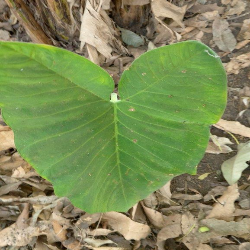

In [ ]:
for img in imgs:
  print(img)
  display_image(img)

In [ ]:
tlb_early_files = []
tlb_free_files = []
tlb_mid_files = []
tlb_late_files = []

In [ ]:
for key, value in tlb_late.items():
  tlb_late_files.append(key)

print(len(tlb_late_files))

29


In [ ]:
print(len(tlb_late_files))

29


In [ ]:
import cv2
import numpy as np
import re

def get_duplicates_with_filename(fs):
    identicals = {}
    for i in range(len(fs)):
      i_identicals = []
      for j in range(6):
        if i+j > len(fs) - 1:
          continue
        if are_images_identical3(fs[i], fs[i+j]):
          i_identicals.append(fs[i+j])
      identicals[fs[i]] = i_identicals
    return identicals


def are_images_identical3(a, b):
  pattern = r'IMG_(\d{8})_(\d{4})'
  matches1 = re.search(pattern, a)
  matches2 = re.search(pattern, b)

  if matches1 and matches2:
      img_id_1 = matches1.group(1)
      time_code_1 = matches1.group(2)
      img_id_2 = matches2.group(1)
      time_code_2 = matches2.group(2)
      if img_id_1 == img_id_2 and time_code_1 == time_code_2:
        return True
      else:
        return False
  else:
      return False

In [ ]:
fss = [tlb_early_files, tlb_free_files, tlb_mid_files, tlb_late_files]

duplicates_all = []
for fs in fss:
  duplicates = get_duplicates_with_filename(fs)
  duplicates_all.append(duplicates)
  print(f"\n{duplicates}")


{'/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134407_823.jpg': ['/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134407_823.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134408_849.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134409_728.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134421_282.jpg'], '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134408_849.jpg': ['/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134408_849.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134409_728.jpg', '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_134421_282.jpg'], '/content/drive/MyDrive/TLB/Taro Leave Blight Images/Taro_Early_Blight/IMG_20240116_1

In [ ]:
'''
1228
'''

print(len(duplicates_all))

4


In [ ]:
count = 0
deleted = []
unique = []
for key, value in duplicates_all[3].items():
    if key in deleted:
        continue
    if key in unique:
        continue
    p = re.compile(r"/content/drive/MyDrive/TLB/")
    unique.append(p.sub("", key))
    if len(value) > 0:
        for v in value:
            if v in deleted:
                continue
            count += 1
            try:
                deleted.append(v)
            except:
                continue

print(len(unique))

7
